In [4]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

<class 'numpy.ndarray'> (240, 320)
255 0


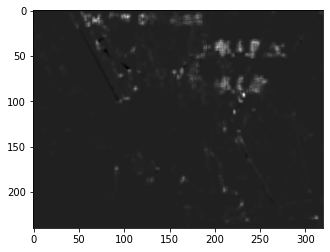

In [11]:
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
color = (0, 255, 0)
first_frame = cv2.imread("../images/images1/frame7.jpg")
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)
mask = np.zeros_like(first_frame)

r=0
for i in range(8,9):
    frame = cv2.imread("../images/images1/frame"+ str(i)+".jpg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = gray.copy()
    prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

    # motion estimation
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 1, 5, 2, 5, 1.1, None)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # plt.imshow(mag, cmap='gray')
    print(type(mag), mag.shape)

    # Calculating feature value M
    dy, dx = np.gradient(gray)
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy
    R_score = np.array(gray.copy(),dtype=np.float64)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            sum_Ix = 0
            sum_Iy = 0
            sum_Ixy = 0
            for k in range(-2,3):
                for l in range(-2,3):
                    if i+k >= 0 and j+l >= 0 and i+k < gray.shape[0] and j+l < gray.shape[1]:
                        sum_Ix += Ixx[i+k][j+l]
                        sum_Iy += Iyy[i+k][j+l]
                        sum_Ixy += Ixy[i+k][j+l]
                    else:
                        sum_Ix += 0
                        sum_Iy += 0
                        sum_Ixy += 0
            det = sum_Ix*sum_Iy - sum_Ixy*sum_Ixy
            trace = sum_Ixy + sum_Ixy
            r = det - 0.05*(trace**2)
            R_score[i][j] = r 
    min_val = np.min(R_score)
    R_score += (-1)*min_val
    max_val = np.max(R_score)
    R_score = (R_score/max_val)*255
    R_score = R_score.astype(int)
    print(np.max(R_score),np.min(R_score) )
    plt.imshow(R_score, cmap="gray")
    break
    good_old = prev[status == 1].astype(int)
    good_new = next[status == 1].astype(int)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        frame = cv2.circle(frame, (a, b), 3, color, -1)
    output = cv2.add(frame, mask)
    prev_gray = gray.copy()
    prev = good_new.reshape(-1, 1, 2)
    mask = np.zeros_like(frame)
    plt.imsave('images/output_trial1/frame'+ str(r)+'.jpg',output)
    r += 1